In [1]:
!pip install texthero
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import texthero as hero

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     |████████████████████████████████| 1.5 MB 935 kB/s eta 0:00:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

preprocessing 0.1.13 requires nltk==3.2.4, but you'll have nltk 3.6.2 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [2]:
## leitura
df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')

In [3]:
list(df.columns)

['Id',
 'ProductId',
 'UserId',
 'ProfileName',
 'HelpfulnessNumerator',
 'HelpfulnessDenominator',
 'Score',
 'Time',
 'Summary',
 'Text']

## Tratamento e EDA?

In [4]:
#queremos apenas as colunas summary, text e score
df = df[['Summary', 'Text', 'Score']]
df = df.rename(str.lower, axis='columns')
df.head()


,summary,text,score
0,Good Quality Dog Food,I have bought several of the Vitality canned d...,5
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1
2,"""Delight"" says it all",This is a confection that has been around a fe...,4
3,Cough Medicine,If you are looking for the secret ingredient i...,2
4,Great taffy,Great taffy at a great price. There was a wid...,5


In [5]:
df['text'] = hero.clean(df['text'])


In [6]:
print(len(df))
df = df.drop_duplicates()
print(len(df))

568454
394710


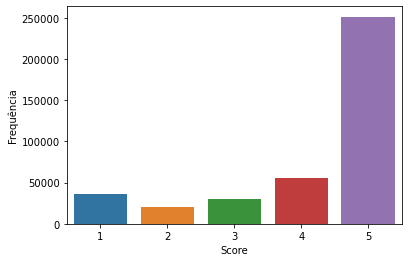

In [7]:
import seaborn as sns 
import matplotlib.pyplot as plt 

ax = sns.countplot(df['score']) 
ax.set(xlabel='Score', ylabel='Frequência')
plt.show()


 - dados desbalanceados

## Modelos

### Validação cruzada utilizando naive bayes multinomial para as 5 classes

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
teste = Pipeline([('CVec', CountVectorizer(stop_words='english')),
                     ('Tfidf', TfidfTransformer()), 
                     ('MNB', MultinomialNB())])



### Tentativa inicial de naivebayes multinomial (n sei se vale a pena incluir, talvez apenas mencionar)

In [10]:
from sklearn.model_selection import cross_validate
cv_pred = cross_validate(teste,
                             df['text'], 
                             df['score'], 
                             cv=5,
                             scoring=('roc_auc_ovr', 'accuracy'), n_jobs=-1, verbose =10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   49.2s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   49.8s remaining:   33.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


In [11]:
print('roc: ' + str(cv_pred['test_roc_auc_ovr']))
print('acuracia: ' + str(cv_pred['test_accuracy']))

roc: [0.76575797 0.76538489 0.76574188 0.77184195 0.76946176]
acuracia: [0.64323174 0.64296572 0.64349776 0.64338375 0.64357376]


roc meio baix a e acuracia baixa tbm (sera que a gnt deve incluir a roc como medida tbm?)

### Tentativa com naive bayes considerando dados binarios 

In [13]:
tr_where = np.where(df.score <= 3, 0, 1)
#tst = pd.Series(tr_where)
df['score2'] = tr_where
df.tail()

,summary,text,score,score2
568449,Will not do without,great sesame chicken good better resturants ea...,5,1
568450,disappointed,disappointed flavor chocolate notes especially...,2,0
568451,Perfect for our maltipoo,stars small give one training session tried tr...,5,1
568452,Favorite Training and reward treat,best treats training rewarding dog good groomi...,5,1
568453,Great Honey,satisfied product advertised use cereal raw vi...,5,1


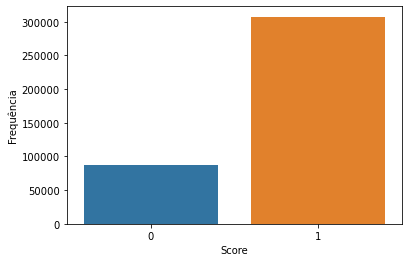

In [14]:
ax = sns.countplot(df['score2']) 
ax.set(xlabel='Score', ylabel='Frequência')
plt.show()

In [15]:
## fazer o split
from sklearn.model_selection import train_test_split

X = df['text']
y = df['score2']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

In [16]:
teste2 = Pipeline([('CVec', CountVectorizer(stop_words='english')),
                     ('Tfidf', TfidfTransformer()),
                     ('BNB', BernoulliNB())])
## validação cruzada na base de treino
cv_pred = cross_validate(teste2,
                             X_train, 
                             y_train, 
                             cv=5,
                             scoring=('roc_auc_ovr', 'accuracy'), n_jobs=-1, verbose =10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   39.6s remaining:   59.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   40.1s remaining:   26.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


In [17]:
print('roc: ' + str(cv_pred['test_roc_auc_ovr']))
print('acuracia: ' + str(cv_pred['test_accuracy']))

roc: [0.88550904 0.88295777 0.87826682 0.88225714 0.88287558]
acuracia: [0.83790417 0.8351015  0.83111125 0.83551059 0.83733156]


### Regressão logistica

In [18]:
from sklearn.linear_model import LogisticRegression
teste3 = Pipeline([('CVec', CountVectorizer(stop_words='english')),
                     ('Tfidf', TfidfTransformer()),
                  ('logreg', LogisticRegression(max_iter = 1000))])

cv_pred = cross_validate(teste3,
                             X_train, 
                             y_train, 
                             cv=5,
                             scoring=('roc_auc_ovr', 'accuracy'), n_jobs=-1, verbose =10)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  1.1min remaining:   45.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


In [19]:
print('roc: ' + str(cv_pred['test_roc_auc_ovr']))
print('acuracia: ' + str(cv_pred['test_accuracy']))

roc: [0.92678252 0.92631873 0.92562148 0.92562615 0.92571051]
acuracia: [0.88654717 0.88456788 0.88776641 0.88602283 0.88603867]


#### teste regressao logistica

In [20]:
result = teste3.fit(X_train, y_train)

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
print("TREINO:")
print(classification_report(y_train, result.predict(X_train), digits = 3))

TREINO:
              precision    recall  f1-score   support

           0      0.840     0.669     0.745     69724
           1      0.911     0.964     0.937    246044

    accuracy                          0.899    315768
   macro avg      0.876     0.816     0.841    315768
weighted avg      0.896     0.899     0.895    315768



###### teste

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, result.predict(X_test), digits = 3))

              precision    recall  f1-score   support

           0      0.801     0.635     0.708     17376
           1      0.903     0.955     0.928     61566

    accuracy                          0.885     78942
   macro avg      0.852     0.795     0.818     78942
weighted avg      0.880     0.885     0.880     78942



In [23]:
confusion_matrix(y_test, result.predict(X_test))

array([[11028,  6348],
       [ 2746, 58820]])

com acuracia alta mas prediz mt melhor pra classe de maior frequencia, pra outra ele acerta em torno de 63%, que não é maneiro

#### teste nb

In [24]:
result2 = teste2.fit(X_train, y_train)
print("TREINO:")
print(classification_report(y_train, result2.predict(X_train), digits = 3))

TREINO:
              precision    recall  f1-score   support

           0      0.678     0.593     0.633     69724
           1      0.889     0.920     0.904    246044

    accuracy                          0.848    315768
   macro avg      0.783     0.757     0.769    315768
weighted avg      0.842     0.848     0.844    315768



In [25]:

print(classification_report(y_test, result2.predict(X_test), digits = 3))

              precision    recall  f1-score   support

           0      0.648     0.552     0.596     17376
           1      0.879     0.915     0.897     61566

    accuracy                          0.835     78942
   macro avg      0.763     0.734     0.746     78942
weighted avg      0.828     0.835     0.830     78942



In [26]:
confusion_matrix(y_test, result2.predict(X_test))

array([[ 9599,  7777],
       [ 5224, 56342]])

In [ ]:
#confusion_matrix(df['score2'], result.predict(df['text']))

da pra ver que a acuracia da alta beleza. olhando p performace ali separadamente a gnt ve que grande parte do motivo da acuracia alta é o desbalanceamento, ai a gnt usa isso como justificativa pra fazer balanceado

## Procedimento com balanceamento dos dados usando downsampling

Downsampling é uma técnica usada para balancear os dados que consite em tirar uma amostra da classe com maior frequencia para igualar com a classe de menor frequencia. Tem outras estrategia como repetir as observações da classe com freq menor (acho que é chamado upsampling). tem tambem um tal de smote que tinha sido mencionado em algum slide, talvez valha só mencionar que tem outras mas escolhemos essa por ser mais simples e facil de explicar

In [27]:
from sklearn.utils import resample

df1 = df[df.score2==0]
df2 = df[df.score2==1]
 
# Retirando uma amostra do tamanho da base amostra que tem o score = 0
df2_downsampled = resample(df2,
               replace = False,    
               n_samples=len(df1), 
               random_state=42) 
 
# Combine minority class with downsampled majority class
df = pd.concat([df1, df2_downsampled])
 
# Display new class counts
df.score2.value_counts()

1    87100
0    87100
Name: score2, dtype: int64

#### Divisão treino-teste

In [28]:
from sklearn.model_selection import train_test_split
X = df['text']
y = df['score2']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)

In [29]:
pipeline_NB = Pipeline([('CVec', CountVectorizer(stop_words='english')),
                        ('Tfidf', TfidfTransformer()),
                        ('BNB', BinomialNB())])

pipeline_logreg = Pipeline([('CVec', CountVectorizer(stop_words='english')),
                        ('Tfidf', TfidfTransformer()),
                        ('LREG', LogisticRegression(max_iter = 1000))])

# 5-fold cross-validation no treino para ambos os modelos
cv1 = cross_validate(pipeline_NB,
                     X_train, 
                     y_train, 
                     cv=5,
                     scoring=('roc_auc_ovr', 'accuracy'), n_jobs=-1, verbose =10)

cv2 = cross_validate(pipeline_logreg,
                     X_train, 
                     y_train, 
                     cv = 5,
                     scoring=('roc_auc_ovr', 'accuracy'), n_jobs=-1, verbose =10)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   17.7s remaining:   26.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   17.8s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   25.7s remaining:   38.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   26.1s remaining:   17.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.5s finished


In [40]:
pipeline_MNB = Pipeline([('CVec', CountVectorizer(stop_words='english')),
                        ('Tfidf', TfidfTransformer()),
                        ('MNB', MultinomialNB())])


# 5-fold cross-validation no treino para ambos os modelos
cv3 = cross_validate(pipeline_MNB,
                     X_train, 
                     y_train, 
                     cv=5,
                     scoring=('roc_auc_ovr', 'accuracy'), n_jobs=-1, verbose =10)

print("Resultados para o MNB:")
print('roc: ' + str(cv3['test_roc_auc_ovr']))
print('acuracia: ' + str(cv3['test_accuracy']))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   19.4s remaining:   29.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   19.6s remaining:   13.1s


Resultados para o MNB:
roc: [0.90033121 0.8986116  0.90284911 0.90503598 0.90125799]
acuracia: [0.819281   0.81859931 0.82294059 0.82545207 0.82304822]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.6s finished


In [32]:
print("Resultados para o NB:")
print('roc: ' + str(cv1['test_roc_auc_ovr']))
print('acuracia: ' + str(cv1['test_accuracy']))

Resultados para o NB:
roc: [0.88228243 0.88211654 0.88631492 0.88365494 0.88508601]
acuracia: [0.78989667 0.79158295 0.79613949 0.78986079 0.79294633]


In [33]:
print("Resultados para a regressão logística:")
print('roc: ' + str(cv2['test_roc_auc_ovr']))
print('acuracia: ' + str(cv2['test_accuracy']))

Resultados para a regressão logística:
roc: [0.92203203 0.92062655 0.92211078 0.92489159 0.92168691]
acuracia: [0.84525689 0.84306831 0.84554392 0.8492035  0.84690729]


In [44]:
## ajuste do modelo e avaliação na base de treino
results1 = pipeline_NB.fit(X_train, y_train)
results2 = pipeline_logreg.fit(X_train, y_train)
results3 = pipeline_MNB.fit(X_train, y_train)

### Performances no treino

In [ ]:
print(classification_report(y_train, results1.predict(X_train), digits = 3))

In [ ]:
print(classification_report(y_train, results2.predict(X_train), digits = 3))

### Resultados no teste

In [35]:
print(classification_report(y_test, results1.predict(X_test), digits = 3))

              precision    recall  f1-score   support

           0      0.843     0.726     0.780     17338
           1      0.761     0.866     0.810     17502

    accuracy                          0.796     34840
   macro avg      0.802     0.796     0.795     34840
weighted avg      0.802     0.796     0.795     34840



In [36]:
print(classification_report(y_test, results2.predict(X_test), digits = 3))

              precision    recall  f1-score   support

           0      0.847     0.853     0.850     17338
           1      0.854     0.847     0.850     17502

    accuracy                          0.850     34840
   macro avg      0.850     0.850     0.850     34840
weighted avg      0.850     0.850     0.850     34840



In [45]:
## Resultados do NB MULTINOMIAL VAMO USAR ESSE QUE FICOU BONZAO
print(classification_report(y_test, results3.predict(X_test), digits = 3))

              precision    recall  f1-score   support

           0      0.825     0.821     0.823     17338
           1      0.824     0.828     0.826     17502

    accuracy                          0.825     34840
   macro avg      0.825     0.824     0.825     34840
weighted avg      0.825     0.825     0.825     34840



In [43]:
pipeline_MNB

Pipeline(steps=[('CVec', CountVectorizer(stop_words='english')),
                ('Tfidf', TfidfTransformer()), ('BNB', MultinomialNB())])

 - matrizes de confusão

In [48]:
confusion_matrix(y_test, results1.predict(X_test)) #BINOMIAL NB

array([[12588,  4750],
       [ 2341, 15161]])

In [49]:
confusion_matrix(y_test, results2.predict(X_test)) #REG LOG

array([[14796,  2542],
       [ 2680, 14822]])

In [50]:
confusion_matrix(y_test, results3.predict(X_test)) # MULTINOMIAL NB

array([[14234,  3104],
       [ 3010, 14492]])

In [ ]:
#curiosidade
#confusion_matrix(df2['score2'], results1.predict(df2['text']))

In [ ]:
#hmm = pipeline_logreg['Tfidf']
#hmm.fit_transform(CountVectorizer(stop_words='english').fit_transform(X_test[0]))
#print(len(df1))
#len(df2)
corpus = X_train

pipe = Pipeline([('count', CountVectorizer(stop_words = 'english')),
                 ('tfid', TfidfTransformer())]).fit(corpus)


In [ ]:
print(pipe.transform(corpus)[0]) # ja vai dar o tf e df que seria uma matriz esparça aí ele representa dessa forma
print(X_train[0])
print(pipe.transform(corpus).shape) #nosso vocabulario tinha entao 71758 palavras 

In [ ]:
vc = CountVectorizer(stop_words = 'english')
vect = vc.fit_transform(X_train)
vect.shape # a nossa matriz esparça tem essa dimensão (num_de_docs x tamanho_vocab = 139360 x 71758)

### Brincando com os nossos modelos

In [ ]:
print(results1.predict(['this is a really bad food']))
print(results2.predict(['this is a really bad food'])) #errado haha

In [ ]:
print(results1.predict(['i loved this food so much']))
print(results2.predict(['i loved this food so much']))

In [ ]:
print(results1.predict(['the worst dog food i ever had']))
print(results2.predict(['the worst dog food i ever had']))
print(results1.predict(['the best dog food i ever had']))
print(results2.predict(['the best dog food i ever had']))


In [ ]:
print(results1.predict(['i have a mixed opinion about this food it has some good stuff and some bad stuff'])) # errou
print(results2.predict(['i have a mixed opinion about this food it has some good stuff and some bad stuff']))

In [ ]:
print(results1.predict(['BAD FOOD DO NOT BUY IT I HATED IT IT IS THE WORST']))
print(results2.predict(['BAD FOOD DO NOT BUY IT I HATED IT IT IS THE WORST']))
print(results1.predict(['BAD FOOD DO NOT BUY IT I HATED IT'])) # WORST É UMA PALAVRA MUITO IMPORTANTE PRO PRIMEIRO
print(results2.predict(['BAD FOOD DO NOT BUY IT I HATED IT']))

In [53]:
#df_remov = df2 - df
df_remov = df2[df2.text.isin(df.text) == False]
x_removido = df_remov['text']
y_removido = df_remov['score2']
print(print(classification_report(y_removido, results1.predict(x_removido), digits = 3)))
print(print(classification_report(y_removido, results2.predict(x_removido), digits = 3)))
print(print(classification_report(y_removido, results3.predict(x_removido), digits = 3)))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           1      1.000     0.864     0.927    219920

    accuracy                          0.864    219920
   macro avg      0.500     0.432     0.464    219920
weighted avg      1.000     0.864     0.927    219920

None


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           1      1.000     0.846     0.916    219920

    accuracy                          0.846    219920
   macro avg      0.500     0.423     0.458    219920
weighted avg      1.000     0.846     0.916    219920

None


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           1      1.000     0.828     0.906    219920

    accuracy                          0.828    219920
   macro avg      0.500     0.414     0.453    219920
weighted avg      1.000     0.828     0.906    219920

None


In [ ]:
df2.head()

In [ ]:
from sklearn.linear_model import LogisticRegression
def text_fit(X, y, model,clf_model,coef_show=1):
    
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=42, test_size = 0.2)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = model['count'].get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).sort_values(['Coefficient']).to_string(index=False))
    
#c = CountVectorizer(stop_words = 'english')
c = Pipeline([('count', CountVectorizer(stop_words = 'english')),
                 ('tfid', TfidfTransformer())])

text_fit(X, y, c, LogisticRegression(max_iter = 1000))

In [ ]:
#text_fit(X, y, c, LogisticRegression())

# Abordagem com redes neurais (não vai rolar dessa vez)

pode ser meio overkill dado o que ja temos kkkk vai rolar nao

In [ ]:
#from keras.models import Sequential
#from keras.layers import Dense, SimpleRNN, LSTM
#from keras.utils import to_categorical

In [ ]:
#X = np.array(list(df['tfidf']))
#len_treino = int(.8*X.shape[0])
#inds = np.random.choice(range(X.shape[0]), len_treino, replace = False)
#
#x_treino = X[inds].reshape((-1, 100, 1))
#x_teste = X[inds].reshape((-1, 100, 1))
#y_treino = to_categorical(np.array(df['score'])[inds])
#y_teste = to_categorical(np.delete(np.array(df['score']), inds))

In [ ]:
#model = Sequential()
#model.add(SimpleRNN(128, input_shape = (X.shape[1],1), activation = 'sigmoid'))
#model.add(Dense(1, activation = 'softmax'))
#
#model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [ ]:
## ainda n rolou
#history = model.fit(x_treino, y_treino, epochs = 1, batch_size = 16) 